In [27]:
import pandas as pd
dating = pd.read_csv("profiles.csv")

In [28]:
# basic data cleanup
# income
dating.loc[dating["income"] == -1, "income"] = pd.NA

# Let's create ML algorithm that will predict drug use

prepare data some more for drug investigation

In [29]:
# create some suspicios words list that may relate to drug use to filter from essays
drug_words = ["party", "fun", "hang out", "festival", "good time", "drink"]
essay_cols = [col for col in dating.columns if col.startswith("essay")]
for word in drug_words:
    dating[word + "_count"] = dating[essay_cols].apply(
        lambda row: sum(str(cell).lower().count(word) for cell in row if pd.notna(cell)),
        axis=1
    )
    
dating = dating.drop(columns=essay_cols)

Prepare data for machine learning

In [30]:
drugs_values = dating["drugs"].value_counts()
dating_drugs_filled = dating.dropna(subset=["drugs"])
dating_drugs_missing = dating[dating["drugs"].isna()]
features = dating_drugs_filled.drop(columns=["drugs"])
labels = dating_drugs_filled["drugs"]
features["education"][features["education"].str.contains("graduated", na=False)].value_counts()
features["religion"].value_counts()
labels.value_counts(normalize=True)

drugs
never        0.822483
sometimes    0.168578
often        0.008939
Name: proportion, dtype: float64

In [31]:
# prepare features for ML
features = pd.get_dummies(features, columns=["body_type", "drinks", "job", "orientation", "pets"], dummy_na=False)

from tools import bucket_education, is_strict_diet

# extract most common single ethnicities (about 5), rest as "other"
# literal list based on value_counts and inspection
ethnicities = [
    "white",
    "asian",
    "black",
    "hispanic / latin",
    "other",
    "middle eastern",
    "native american",
    "pacific islander",
    "indian"
]
for ethn in ethnicities:
    features[ethn] = features["ethnicity"].apply(lambda val: True if pd.notna(val) and ethn in val else False)

features["education_bucket"] = features["education"].apply(bucket_education)
features = pd.get_dummies(features, columns=["education_bucket"], dummy_na=False)
features["male"] = features["sex"].apply(lambda val: True if val == "m" else False)
features["smokes"] = features["smokes"].apply(lambda val: False if val == "no" else True)
features["is_single"] = features["status"].apply(lambda val: True if val == "single" else False)
features["has_kid_s"] = features["offspring"].apply(lambda val: True if pd.notna(val) and "has" in val else False)
features["strict_diet"] = features["diet"].apply(is_strict_diet)
features["strict_religion"] = features["religion"].apply(lambda val: True if pd.notna(val) and "very serious about it" in val else False)
diets = ["vegan", "vegetarian", "halal", "kosher"]
for diet in diets:
    features[diet] = features["diet"].apply(lambda val: True if pd.notna(val) and diet in val else False)

features = features.select_dtypes(include=["number", "bool"])

In [32]:
# just to verify the bucketing is working as intended
education_unique = dating["education"].dropna().unique()
education_buckets = {edu: bucket_education(edu) for edu in education_unique}
education_buckets

{'working on college/university': 'high_school',
 'working on space camp': 'lower',
 'graduated from masters program': 'graduated',
 'graduated from college/university': 'graduated',
 'working on two-year college': 'high_school',
 'graduated from high school': 'high_school',
 'working on masters program': 'high_school',
 'graduated from space camp': 'high_school',
 'college/university': 'graduated',
 'dropped out of space camp': 'lower',
 'graduated from ph.d program': 'Ph.D',
 'graduated from law school': 'high_school',
 'working on ph.d program': 'graduated',
 'two-year college': 'graduated',
 'graduated from two-year college': 'graduated',
 'working on med school': 'lower',
 'dropped out of college/university': 'high_school',
 'space camp': 'high_school',
 'graduated from med school': 'high_school',
 'dropped out of high school': 'lower',
 'working on high school': 'lower',
 'masters program': 'graduated',
 'dropped out of ph.d program': 'graduated',
 'dropped out of two-year colleg

## First, we try to predict all three label categories

let's go with decision tree model first

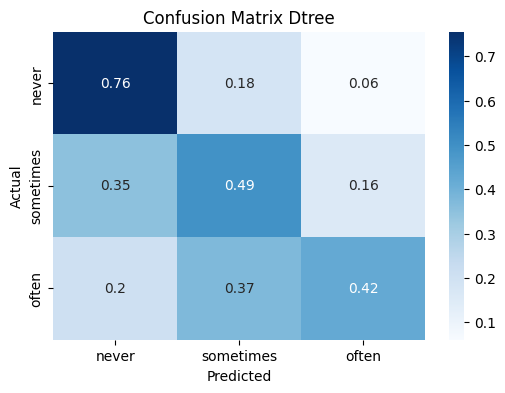

0.4409341064834189

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

score_dict = {}

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=21)
dtree = DecisionTreeClassifier(class_weight="balanced", max_depth=10, random_state=10)
dtree.fit(x_train, y_train)

cm_dtree = confusion_matrix(y_test, dtree.predict(x_test), normalize="true", labels=['never', 'sometimes', 'often'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dtree, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Dtree')
plt.show()
score_dict["f1_dtree"] = f1_score(y_test, dtree.predict(x_test), average="macro")
score_dict["recalls_dtree"] = recall_score(y_test, dtree.predict(x_test), average=None, labels=['never', 'sometimes', 'often'])
f1_score(y_test, dtree.predict(x_test), average="macro")

We see not so great performance by the decision tree model.

Let's try regression model.

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# scale and normalise data for use with regression models
ord_map = {'never': 0, 'sometimes': 1, 'often': 2}
labels = labels.map(ord_map)
scaler = StandardScaler()
imputer = SimpleImputer(strategy="median")
# Apply scaler only to int and float columns
num_cols = features.select_dtypes(include=["int", "float"]).columns
features[num_cols] = scaler.fit_transform(features[num_cols])
features[num_cols] = imputer.fit_transform(features[num_cols])


In [35]:
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=21)
log_regressor = LogisticRegression(random_state=10, max_iter=1000)
log_regressor.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=10)

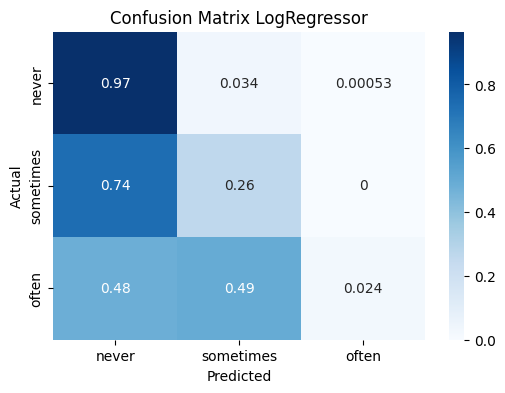

0.43880106121685936

In [36]:
y_pred = log_regressor.predict(x_test)

cm = confusion_matrix(y_test, y_pred, normalize="true", labels=[0, 1, 2])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix LogRegressor')
plt.show()
score_dict["f1_logreg"] = f1_score(y_test, y_pred, average="macro")
f1_score(y_test, y_pred, average="macro")

still far from working model, let's try custom thresholding to improve the predictions

Best 'often' thresh: 0.09896755439047003 F1_often: 0.24581005586542443
Best 'sometimes' thresh: 0.2382997131172823 F1_sometimes: 0.5107451855981718


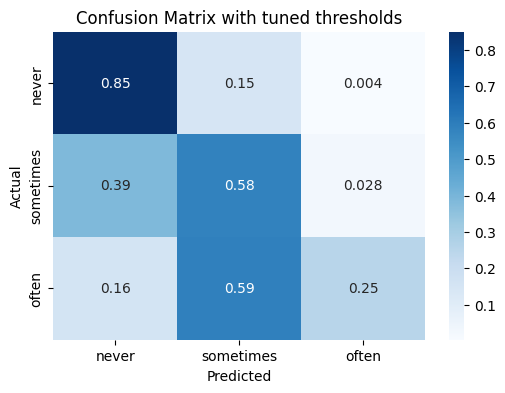

0.5399682757763268

In [37]:
from tools import get_best_thresholds, predict_with_thresholds

probs = log_regressor.predict_proba(x_test)

t_opt_o, t_opt_s = get_best_thresholds(probs, y_test)

y_pred_thr = predict_with_thresholds(probs, t_opt_o, t_opt_s)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds')
plt.show()
score_dict["f1_logreg_customthresh"] = f1_score(y_test, y_pred_thr, average="macro")
f1_score(y_test, y_pred_thr, average="macro")

In [38]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'C': np.linspace(5, 20, 50)}
grid_regressor = GridSearchCV(log_regressor, param_grid, scoring="f1_macro", cv=5, n_jobs=-1)
grid_regressor.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=10),
             n_jobs=-1,
             param_grid={'C': array([ 5.        ,  5.30612245,  5.6122449 ,  5.91836735,  6.2244898 ,
        6.53061224,  6.83673469,  7.14285714,  7.44897959,  7.75510204,
        8.06122449,  8.36734694,  8.67346939,  8.97959184,  9.28571429,
        9.59183673,  9.89795918, 10.20408163, 10.51020408, 10.81632653,
       11.12244898, 11.42857143, 11.73469388, 12.04081633, 12.34693878,
       12.65306122, 12.95918367, 13.26530612, 13.57142857, 13.87755102,
       14.18367347, 14.48979592, 14.79591837, 15.10204082, 15.40816327,
       15.71428571, 16.02040816, 16.32653061, 16.63265306, 16.93877551,
       17.24489796, 17.55102041, 17.85714286, 18.16326531, 18.46938776,
       18.7755102 , 19.08163265, 19.3877551 , 19.69387755, 20.        ])},
             scoring='f1_macro')

Best 'often' thresh: 0.126133995028186 F1_often: 0.24324324324275065
Best 'sometimes' thresh: 0.24001032142851034 F1_sometimes: 0.513004980630391


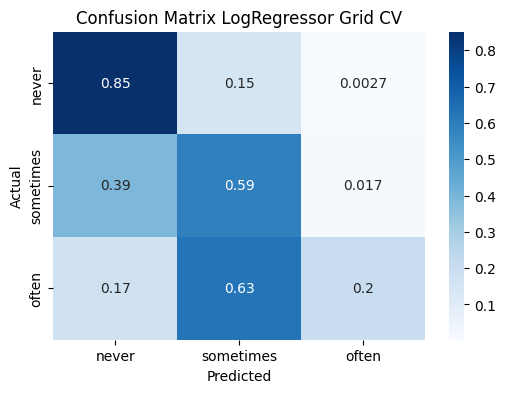

0.5401268029060469

In [39]:
# evaluate performance
probs = grid_regressor.predict_proba(x_test)

t_opt_o, t_opt_s = get_best_thresholds(probs, y_test)

y_pred_thr = predict_with_thresholds(probs, t_opt_o, t_opt_s)

cm_log_reg_tuned_c = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log_reg_tuned_c, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix LogRegressor Grid CV')
plt.show()
f1_score(y_test, y_pred_thr, average="macro")
score_dict["f1_logreg_tuned"] = f1_score(y_test, y_pred_thr, average="macro")
score_dict["recalls_logreg_tuned"] = recall_score(y_test, y_pred_thr, average=None, labels=[0, 1, 2])
f1_score(y_test, y_pred_thr, average="macro")

reduce features to see how it affects performance

In [40]:
from sklearn.feature_selection import RFE

rfe = RFE(
    estimator=log_regressor,
    n_features_to_select=45,
    step=5,           # remove 5 features per iteration
)

# 3) fit only on train
rfe.fit(x_train, y_train)

# 4) transform your sets
x_train_rfe = rfe.transform(x_train)
x_test_rfe  = rfe.transform(x_test)

print("Kept features:", x_train_rfe.shape[1])
kept_feature_names = [x_train.columns[i] for i, keep in enumerate(rfe.support_) if keep]
print("Kept feature names:", kept_feature_names)

grid_regressor.fit(x_train_rfe, y_train)

Kept features: 45
Kept feature names: ['age', 'smokes', 'body_type_athletic', 'body_type_fit', 'body_type_jacked', 'body_type_overweight', 'body_type_rather not say', 'body_type_skinny', 'body_type_used up', 'drinks_desperately', 'drinks_often', 'drinks_rarely', 'drinks_socially', 'drinks_very often', 'job_artistic / musical / writer', 'job_banking / financial / real estate', 'job_entertainment / media', 'job_military', 'job_rather not say', 'job_retired', 'job_unemployed', 'orientation_bisexual', 'orientation_gay', 'orientation_straight', 'pets_dislikes dogs', 'pets_dislikes dogs and dislikes cats', 'pets_dislikes dogs and likes cats', 'pets_has cats', 'pets_has dogs and likes cats', 'pets_likes cats', 'pets_likes dogs and has cats', 'pets_likes dogs and likes cats', 'white', 'asian', 'other', 'indian', 'education_bucket_Ph.D', 'education_bucket_lower', 'male', 'is_single', 'strict_diet', 'strict_religion', 'vegan', 'halal', 'kosher']


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=10),
             n_jobs=-1,
             param_grid={'C': array([ 5.        ,  5.30612245,  5.6122449 ,  5.91836735,  6.2244898 ,
        6.53061224,  6.83673469,  7.14285714,  7.44897959,  7.75510204,
        8.06122449,  8.36734694,  8.67346939,  8.97959184,  9.28571429,
        9.59183673,  9.89795918, 10.20408163, 10.51020408, 10.81632653,
       11.12244898, 11.42857143, 11.73469388, 12.04081633, 12.34693878,
       12.65306122, 12.95918367, 13.26530612, 13.57142857, 13.87755102,
       14.18367347, 14.48979592, 14.79591837, 15.10204082, 15.40816327,
       15.71428571, 16.02040816, 16.32653061, 16.63265306, 16.93877551,
       17.24489796, 17.55102041, 17.85714286, 18.16326531, 18.46938776,
       18.7755102 , 19.08163265, 19.3877551 , 19.69387755, 20.        ])},
             scoring='f1_macro')

Best 'often' thresh: 0.07984974488857992 F1_often: 0.2212389380526326
Best 'sometimes' thresh: 0.22459833372512503 F1_sometimes: 0.5046987285788409


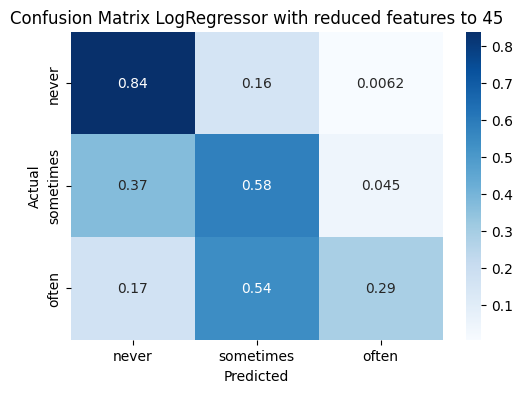

0.5275299793465826

In [41]:
probs_test = grid_regressor.predict_proba(x_test_rfe)
t_opt_o, t_opt_s = get_best_thresholds(probs=probs_test, y_test=y_test)
y_pred_thr = predict_with_thresholds(probs_test, t_opt_o, t_opt_s)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix LogRegressor with reduced features to 45')
plt.show()
score_dict["f1_logreg_rfe"] = f1_score(y_test, y_pred_thr, average="macro")
f1_score(y_test, y_pred_thr, average="macro")

we did not worsen the performance much by reducing the features!

## Now let's try just binary classification - drugs or not - if we can get better

In [61]:
labels_binary = (labels != 0)
x_train, x_test, y_train, y_test = train_test_split(features, labels_binary, test_size=.2, random_state=21)
binary_scores = {}

Dtree basic

In [43]:
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=10)

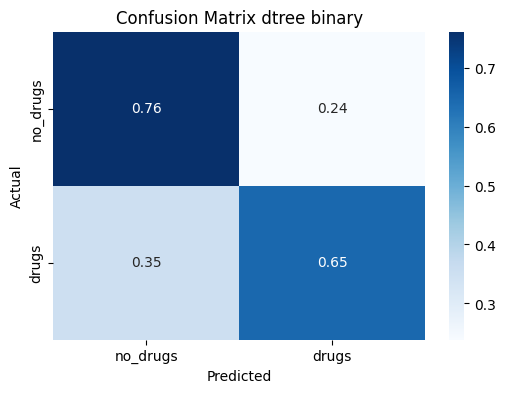

0.6509244323514779

In [62]:
cm = confusion_matrix(y_test, dtree.predict(x_test), normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix dtree binary')
plt.show()
binary_scores["Decision Tree"] = f1_score(y_test, dtree.predict(x_test), average="macro")
f1_score(y_test, dtree.predict(x_test), average="macro")

regression model with binary labels

In [45]:
grid_regressor.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=10),
             n_jobs=-1,
             param_grid={'C': array([ 5.        ,  5.30612245,  5.6122449 ,  5.91836735,  6.2244898 ,
        6.53061224,  6.83673469,  7.14285714,  7.44897959,  7.75510204,
        8.06122449,  8.36734694,  8.67346939,  8.97959184,  9.28571429,
        9.59183673,  9.89795918, 10.20408163, 10.51020408, 10.81632653,
       11.12244898, 11.42857143, 11.73469388, 12.04081633, 12.34693878,
       12.65306122, 12.95918367, 13.26530612, 13.57142857, 13.87755102,
       14.18367347, 14.48979592, 14.79591837, 15.10204082, 15.40816327,
       15.71428571, 16.02040816, 16.32653061, 16.63265306, 16.93877551,
       17.24489796, 17.55102041, 17.85714286, 18.16326531, 18.46938776,
       18.7755102 , 19.08163265, 19.3877551 , 19.69387755, 20.        ])},
             scoring='f1_macro')

Best threshold: 0.24429701450173844, F1: 0.5393669892749476


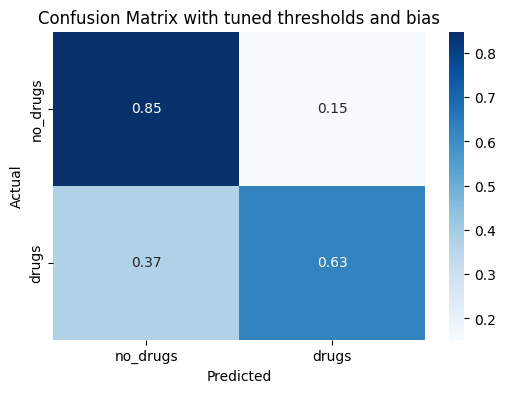

0.6553571250174829

In [63]:
from tools import get_best_thresh_binary
best_thr = get_best_thresh_binary(grid_regressor.predict_proba(x_test)[:, 1], y_test)
y_pred_thr = (grid_regressor.predict_proba(x_test)[:, 1] >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and bias')
plt.show()
binary_scores["Regression"] = f1_score(y_test, grid_regressor.predict(x_test), average="macro")
f1_score(y_test, grid_regressor.predict(x_test), average="macro")

we get significantly better performance using binary labels, with dtree more accurate overall while regressor more restricted in misclassifying someone as drug user (if that would be our concern)

Last model to try - random forest classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42,
)

rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200,
                       random_state=42)

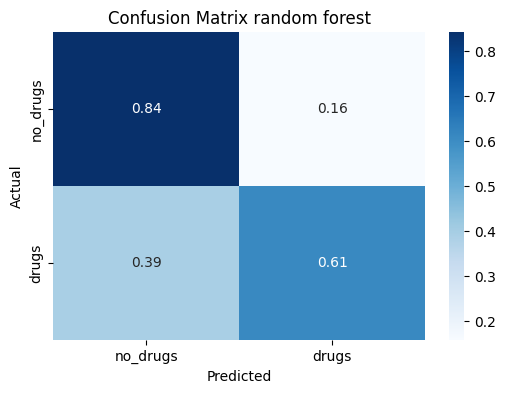

0.6982051515028538

In [64]:
y_pred = rf.predict(x_test)

cm_rf = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix random forest')
plt.show()
binary_scores["Random Forest"] = f1_score(y_test, rf.predict(x_test), average="macro")
f1_score(y_test, rf.predict(x_test), average="macro")

# Review

Generally all models strugle on predicting the drug use, mainly because there are very little "often" datapoints.

Best performing model with all three classes:
F1 - macro: 0.5401268029060469


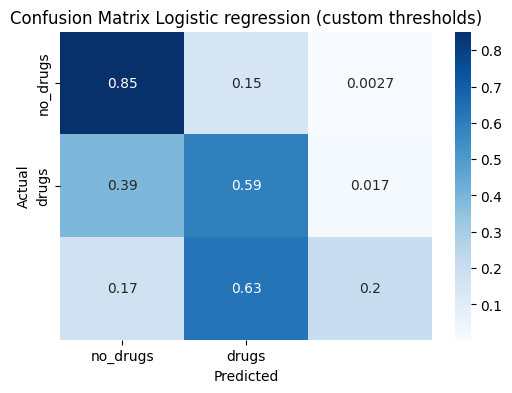

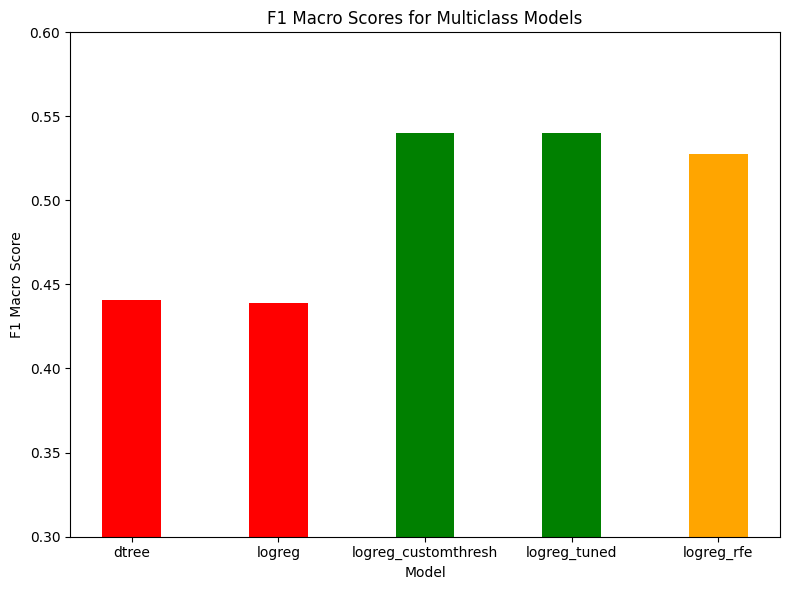

In [69]:
# multiclass models
print("Best performing model with all three classes:")
print(f"F1 - macro: {score_dict["f1_logreg_tuned"]}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log_reg_tuned_c, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Logistic regression (custom thresholds)')
plt.show()

multiclass_keys = [
    k for k in score_dict.keys() if k.startswith('f1_')
]

x_labels = [k.replace('f1_', '') for k in multiclass_keys]
scores = [score_dict[k] for k in multiclass_keys]

plt.figure(figsize=(8, 6))
colors = ['red' if s < 0.5 else 'orange' if s < 0.53 else 'green' for s in scores]
plt.bar(x_labels, scores, color=colors, width=0.4)
plt.ylabel('F1 Macro Score')
plt.xlabel('Model')
plt.title('F1 Macro Scores for Multiclass Models')
plt.ylim(0.3, 0.6)
plt.tight_layout()
plt.show()


Best performing model with binary classification:
F1 - macro: 0.6982051515028538


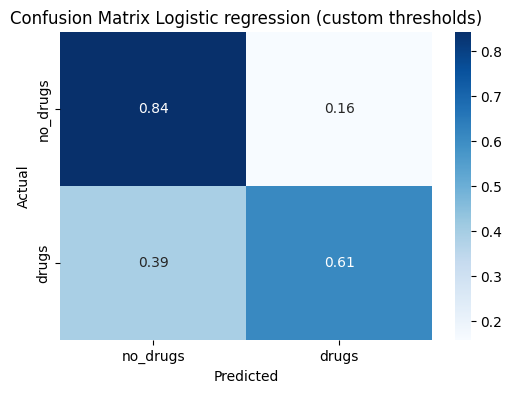

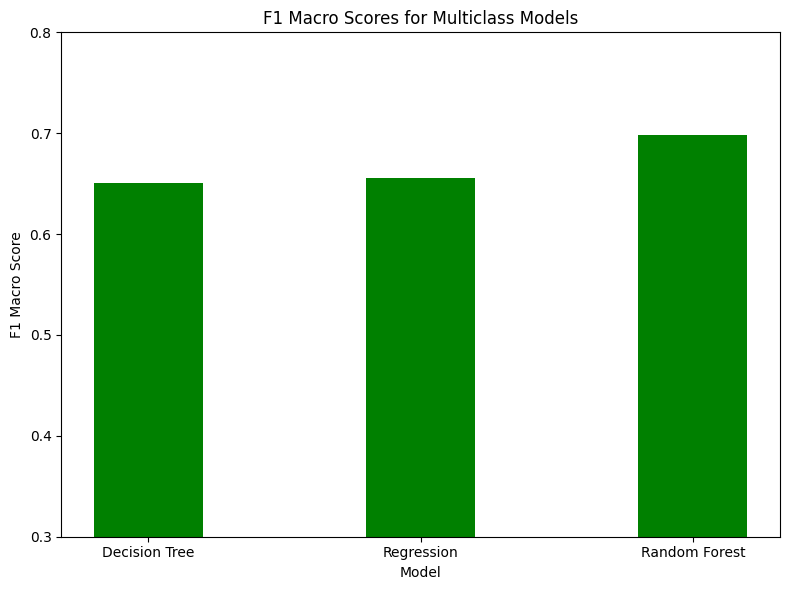

In [71]:
# binary models
print("Best performing model with binary classification:")
print(f"F1 - macro: {binary_scores["Random Forest"]}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Logistic regression (custom thresholds)')
plt.show()


x_labels = binary_scores.keys()
scores = binary_scores.values()

plt.figure(figsize=(8, 6))
colors = ['red' if s < 0.5 else 'orange' if s < 0.53 else 'green' for s in scores]
plt.bar(x_labels, scores, color=colors, width=0.4)
plt.ylabel('F1 Macro Score')
plt.xlabel('Model')
plt.title('F1 Macro Scores for Multiclass Models')
plt.ylim(0.3, 0.8)
plt.tight_layout()
plt.show()